PROJECT OVERVIEW  
Title: Determinants of Happiness: Exploring the Relationship Between Happiness and Socioeconomic Factors (2015–2024)  

Goal: To analyze how economic and social indicators influence happiness globally and build a model that predicts happiness based on these indicators.


In [4]:
# Install scikit-learn if it's missing (fixes "Import could not be resolved" in some environments)
%pip install -q scikit-learn

# First, let's import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Note: you may need to restart the kernel to use updated packages.


DATA PROCESSING

In [5]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# STEP 2: DATA PREPROCESSING - Loading Multiple CSV Files

def load_happiness_data(years_range=range(2015, 2025)):
    """
    Load happiness data from multiple CSV files (2015.csv, 2016.csv, ..., 2024.csv)
    and combine them into a single DataFrame
    """
    all_data = []
    
    for year in years_range:
        filename = f'{year}.csv'
        try:
            # Load the CSV file for this year
            df_year = pd.read_csv(filename)
            
            # Add a Year column if it doesn't exist
            if 'Year' not in df_year.columns:
                df_year['Year'] = year
            
            # Standardize column names (common issues in happiness datasets)
            df_year.columns = df_year.columns.str.strip()  # Remove whitespace
            df_year.columns = df_year.columns.str.replace(' ', '_')  # Replace spaces with underscores
            df_year.columns = df_year.columns.str.lower()  # Convert to lowercase for consistency
            
            print(f"{filename} loaded successfully! Shape: {df_year.shape}")
            all_data.append(df_year)
            
        except FileNotFoundError:
            print(f" {filename} not found. Skipping...")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    if not all_data:
        raise ValueError("No CSV files were successfully loaded!")
    
    # Combine all years into one DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)
    
    print(f"\n Combined dataset shape: {combined_df.shape}")
    print(f"Years included: {combined_df['year'].unique()}")
    print(f" Countries included: {combined_df['country'].nunique()}")
    
    return combined_df

# Load your happiness datasets
print("Loading happiness datasets...")
print("=" * 50)
happiness_df = load_happiness_data(range(2015, 2025))

# Display basic information about the combined dataset
print("\n" + "="*50)
print("COMBINED DATASET OVERVIEW")
print("="*50)
print(happiness_df.info())
print("\nFirst 5 rows:")
print(happiness_df.head())

# Check column names to understand the structure
print("\n COLUMN NAMES IN YOUR DATASET:")
for i, col in enumerate(happiness_df.columns, 1):
    print(f"{i:2d}. {col}")

# Check for common happiness score column names
happiness_score_columns = [col for col in happiness_df.columns if 'happiness' in col.lower() or 'score' in col.lower() or 'ladder' in col.lower()]
print(f"\n🔍 Potential happiness score columns: {happiness_score_columns}")

# Check for common feature columns
common_features = []
for col in happiness_df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['gdp', 'economy', 'income', 'life', 'health', 'social', 'freedom', 'trust', 'generosity', 'support', 'corruption']):
        common_features.append(col)

print(f"🔍 Potential feature columns: {common_features}")

Loading happiness datasets...
2015.csv loaded successfully! Shape: (158, 13)
2016.csv loaded successfully! Shape: (157, 14)
2017.csv loaded successfully! Shape: (155, 13)
2018.csv loaded successfully! Shape: (156, 10)
2019.csv loaded successfully! Shape: (156, 10)
2020.csv loaded successfully! Shape: (153, 21)
2021.csv loaded successfully! Shape: (149, 21)
2022.csv loaded successfully! Shape: (147, 13)
2023.csv loaded successfully! Shape: (137, 20)
2024.csv loaded successfully! Shape: (143, 12)

 Combined dataset shape: (1511, 51)
Years included: [2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]
 Countries included: 192

COMBINED DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 51 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country                                     617 non-null    object 
 1   region      

Clean the above data

In [6]:
# Let's create a comprehensive standardization function for World Happiness Report data
def standardize_world_happiness_data(df):
    """
    Standardize World Happiness Report data across different years
    """
    df_clean = df.copy()
    
    # First, let's handle the country name consistently
    # Use 'country' as the primary country column, fill missing with other country columns
    if 'country' in df_clean.columns and 'country_name' in df_clean.columns:
        df_clean['country'] = df_clean['country'].fillna(df_clean['country_name'])
    if 'country' in df_clean.columns and 'country_or_region' in df_clean.columns:
        df_clean['country'] = df_clean['country'].fillna(df_clean['country_or_region'])
    
    # Handle region/regional indicator
    if 'region' in df_clean.columns and 'regional_indicator' in df_clean.columns:
        df_clean['region'] = df_clean['region'].fillna(df_clean['regional_indicator'])
    
    # STANDARDIZE HAPPINESS SCORES - Create a unified happiness score
    happiness_columns = {
        'primary_score': ['happiness_score', 'happiness.score', 'score', 'ladder_score'],
        'secondary_score': ['ladder_score_in_dystopia']  # Use as backup
    }
    
    # Create unified happiness score
    df_clean['happiness_score'] = None
    
    # Try primary score columns first
    for col in happiness_columns['primary_score']:
        if col in df_clean.columns:
            # Convert to numeric if needed (some might be strings)
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['happiness_score'] = df_clean['happiness_score'].fillna(df_clean[col])
    
    # If still missing, try secondary columns
    for col in happiness_columns['secondary_score']:
        if col in df_clean.columns and df_clean['happiness_score'].isnull().any():
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['happiness_score'] = df_clean['happiness_score'].fillna(df_clean[col])
    
    # STANDARDIZE KEY FEATURES
    # GDP per capita
    gdp_columns = ['economy_(gdp_per_capita)', 'economy..gdp.per.capita.', 'gdp_per_capita', 'logged_gdp_per_capita']
    df_clean['gdp_per_capita'] = None
    for col in gdp_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['gdp_per_capita'] = df_clean['gdp_per_capita'].fillna(df_clean[col])
    
    # Life expectancy
    life_columns = ['health_(life_expectancy)', 'health..life.expectancy.', 'healthy_life_expectancy']
    df_clean['life_expectancy'] = None
    for col in life_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['life_expectancy'] = df_clean['life_expectancy'].fillna(df_clean[col])
    
    # Social support / Family
    social_columns = ['family', 'social_support']
    df_clean['social_support'] = None
    for col in social_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['social_support'] = df_clean['social_support'].fillna(df_clean[col])
    
    # Freedom
    freedom_columns = ['freedom', 'freedom_to_make_life_choices']
    df_clean['freedom'] = None
    for col in freedom_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['freedom'] = df_clean['freedom'].fillna(df_clean[col])
    
    # Corruption/Trust
    trust_columns = ['trust_(government_corruption)', 'trust..government.corruption.', 'perceptions_of_corruption']
    df_clean['trust'] = None
    for col in trust_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            # Note: Corruption is inverse of trust, so we might need to handle this
            if 'corruption' in col.lower():
                df_clean[col] = 1 - df_clean[col]  # Convert corruption to trust
            df_clean['trust'] = df_clean['trust'].fillna(df_clean[col])
    
    # Generosity
    if 'generosity' in df_clean.columns:
        df_clean['generosity'] = pd.to_numeric(df_clean['generosity'], errors='coerce')
    
    # Select only the standardized columns we need
    final_columns = ['country', 'region', 'year', 'happiness_score', 
                    'gdp_per_capita', 'life_expectancy', 'social_support', 
                    'freedom', 'trust', 'generosity']
    
    # Only keep columns that exist in our dataframe
    final_columns = [col for col in final_columns if col in df_clean.columns]
    
    return df_clean[final_columns]

# Apply standardization
print("Standardizing dataset across all years...")
happiness_standardized = standardize_world_happiness_data(happiness_df)

print(f"Standardized dataset shape: {happiness_standardized.shape}")
print(f"Columns: {happiness_standardized.columns.tolist()}")

Standardizing dataset across all years...
Standardized dataset shape: (1511, 10)
Columns: ['country', 'region', 'year', 'happiness_score', 'gdp_per_capita', 'life_expectancy', 'social_support', 'freedom', 'trust', 'generosity']


In [7]:
# Check the results of standardization
print("\n" + "="*60)
print("STANDARDIZED DATASET CHECK")
print("="*60)

print(f"Total records: {len(happiness_standardized)}")
print(f"Records with happiness_score: {happiness_standardized['happiness_score'].notna().sum()}")
print(f"Records with gdp_per_capita: {happiness_standardized['gdp_per_capita'].notna().sum()}")
print(f"Records with life_expectancy: {happiness_standardized['life_expectancy'].notna().sum()}")

print("\nFirst 10 rows of standardized data:")
print(happiness_standardized.head(10))

print("\nMissing values in standardized dataset:")
print(happiness_standardized.isnull().sum())


STANDARDIZED DATASET CHECK
Total records: 1511
Records with happiness_score: 1049
Records with gdp_per_capita: 909
Records with life_expectancy: 1220

First 10 rows of standardized data:
       country                     region  year  happiness_score  \
0  Switzerland             Western Europe  2015              NaN   
1      Iceland             Western Europe  2015              NaN   
2      Denmark             Western Europe  2015              NaN   
3       Norway             Western Europe  2015              NaN   
4       Canada              North America  2015              NaN   
5      Finland             Western Europe  2015              NaN   
6  Netherlands             Western Europe  2015              NaN   
7       Sweden             Western Europe  2015              NaN   
8  New Zealand  Australia and New Zealand  2015              NaN   
9    Australia  Australia and New Zealand  2015              NaN   

   gdp_per_capita  life_expectancy  social_support  freedom    

In [8]:
# Handle missing values in the standardized dataset
def clean_final_dataset(df):
    """Clean and prepare the final dataset for analysis"""
    df_clean = df.copy()
    
    print("Before cleaning:")
    print(f"Total records: {len(df_clean)}")
    print("Missing values:")
    print(df_clean.isnull().sum())
    
    # Remove rows where happiness_score is missing (our target variable)
    df_clean = df_clean.dropna(subset=['happiness_score'])
    
    # For other numeric columns, use median imputation by country
    numeric_cols = ['gdp_per_capita', 'life_expectancy', 'social_support', 'freedom', 'trust', 'generosity']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            # First try to fill with country median
            country_medians = df_clean.groupby('country')[col].transform('median')
            df_clean[col] = df_clean[col].fillna(country_medians)
            
            # Then fill remaining with global median
            global_median = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(global_median)
    
    print(f"\nAfter cleaning:")
    print(f"Total records: {len(df_clean)}")
    print("Missing values:")
    print(df_clean.isnull().sum())
    
    return df_clean

# Apply cleaning
happiness_clean = clean_final_dataset(happiness_standardized)

Before cleaning:
Total records: 1511
Missing values:
country               0
region              894
year                  0
happiness_score     462
gdp_per_capita      602
life_expectancy     291
social_support     1041
freedom             760
trust               291
generosity          290
dtype: int64

After cleaning:
Total records: 1049
Missing values:
country              0
region             747
year                 0
happiness_score      0
gdp_per_capita       0
life_expectancy      0
social_support       0
freedom              0
trust                0
generosity           0
dtype: int64


In [9]:
def clean_happiness_data(df):
    """
    Comprehensive cleaning pipeline for World Happiness Report data (2015-2024)
    Standardizes column names and handles missing values across different years
    """
    df_clean = df.copy()
    
    # 1. STANDARDIZE COUNTRY NAMES
    if 'country' in df_clean.columns and 'country_name' in df_clean.columns:
        df_clean['country'] = df_clean['country'].fillna(df_clean['country_name'])
    if 'country' in df_clean.columns and 'country_or_region' in df_clean.columns:
        df_clean['country'] = df_clean['country'].fillna(df_clean['country_or_region'])
    
    # 2. UNIFY HAPPINESS SCORES (Target Variable)
    happiness_sources = ['happiness_score', 'happiness.score', 'score', 'ladder_score']
    df_clean['happiness_score'] = None
    for col in happiness_sources:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['happiness_score'] = df_clean['happiness_score'].fillna(df_clean[col])
    
    # 3. STANDARDIZE KEY PREDICTORS
    # GDP per capita
    gdp_sources = ['economy_(gdp_per_capita)', 'economy..gdp.per.capita.', 'gdp_per_capita']
    df_clean['gdp_per_capita'] = None
    for col in gdp_sources:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['gdp_per_capita'] = df_clean['gdp_per_capita'].fillna(df_clean[col])
    
    # Life expectancy
    life_sources = ['health_(life_expectancy)', 'health..life.expectancy.', 'healthy_life_expectancy']
    df_clean['life_expectancy'] = None
    for col in life_sources:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['life_expectancy'] = df_clean['life_expectancy'].fillna(df_clean[col])
    
    # Social support
    social_sources = ['family', 'social_support']
    df_clean['social_support'] = None
    for col in social_sources:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean['social_support'] = df_clean['social_support'].fillna(df_clean[col])
    
    # 4. FINAL CLEANING
    # Remove rows missing happiness score
    df_clean = df_clean.dropna(subset=['happiness_score'])
    
    # Impute missing values for predictors
    predictors = ['gdp_per_capita', 'life_expectancy', 'social_support', 'freedom', 'generosity']
    for col in predictors:
        if col in df_clean.columns:
            # Country-level imputation first, then global
            country_median = df_clean.groupby('country')[col].transform('median')
            global_median = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(country_median).fillna(global_median)
    
    # Select final columns
    final_cols = ['country', 'year', 'happiness_score', 'gdp_per_capita', 
                  'life_expectancy', 'social_support', 'freedom', 'generosity']
    final_cols = [col for col in final_cols if col in df_clean.columns]
    
    return df_clean[final_cols]

# Apply the cleaning pipeline
print("Cleaning World Happiness Data (2015-2024)...")
happiness_clean = clean_happiness_data(happiness_df)

print("Cleaning Complete!")
print(f" Final Dataset: {happiness_clean.shape[0]} rows, {happiness_clean.shape[1]} columns")
print(f" Countries: {happiness_clean['country'].nunique()}")
print(f" Years: {happiness_clean['year'].min()} - {happiness_clean['year'].max()}")

# Show results
print("\n First 5 rows of cleaned data:")
display(happiness_clean.head())

print("\n Dataset Overview:")
print(happiness_clean.info())

Cleaning World Happiness Data (2015-2024)...
Cleaning Complete!
 Final Dataset: 1049 rows, 8 columns
 Countries: 170
 Years: 2017 - 2024

 First 5 rows of cleaned data:


,country,year,happiness_score,gdp_per_capita,life_expectancy,social_support,freedom,generosity
315,Norway,2017,7.537,1.616463,0.796667,1.533524,0.635423,0.362012
316,Denmark,2017,7.522,1.482383,0.792566,1.551122,0.626007,0.355280
317,Iceland,2017,7.504,1.480633,0.833552,1.610574,0.627163,0.475540
318,Switzerland,2017,7.494,1.564980,0.858131,1.516912,0.620071,0.290549
319,Finland,2017,7.469,1.443572,0.809158,1.540247,0.617951,0.245483



 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 1049 entries, 315 to 1510
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          1049 non-null   object 
 1   year             1049 non-null   int64  
 2   happiness_score  1049 non-null   float64
 3   gdp_per_capita   1049 non-null   float64
 4   life_expectancy  1049 non-null   float64
 5   social_support   1049 non-null   float64
 6   freedom          1049 non-null   float64
 7   generosity       1049 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 73.8+ KB
None


In [10]:
# --- Add Region Mapping (continent-based) ---
%pip install -q pycountry-convert
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_map = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania'
        }
        return continent_map.get(continent_code, None)
    except:
        return None

# Create region column
happiness_clean['region'] = happiness_clean['country'].apply(country_to_continent)

# Check success
print(happiness_clean[['country', 'region']].head(10))


Note: you may need to restart the kernel to use updated packages.
         country         region
315       Norway         Europe
316      Denmark         Europe
317      Iceland         Europe
318  Switzerland         Europe
319      Finland         Europe
320  Netherlands         Europe
321       Canada  North America
322  New Zealand        Oceania
323       Sweden         Europe
324    Australia        Oceania


EXPLORATORY DATA ANALYSIS - WORLD HAPPINESS REPORT
 DATASET OVERVIEW:
Total countries: 170
Time period: 2017 - 2024
Total observations: 1049
Variables: 9

 DESCRIPTIVE STATISTICS:
              year  happiness_score  gdp_per_capita  life_expectancy  \
count  1049.000000      1049.000000     1049.000000      1049.000000   
mean   2020.189704         5.455880        0.992588        31.774480   
std       2.353990         1.121897        0.403368        30.406554   
min    2017.000000         1.721000        0.000000         0.000000   
25%    2018.000000         4.614000        0.726884         0.691000   
50%    2020.000000         5.493000        1.064578        32.427500   
75%    2023.000000         6.262000        1.314582        64.902000   
max    2024.000000         7.842000        1.870766        77.280000   

       social_support      freedom   generosity  
count     1049.000000  1049.000000  1049.000000  
mean         1.200463     0.414687     0.103144  
std          0.272634

Text(0, 0.5, 'Number of Countries')

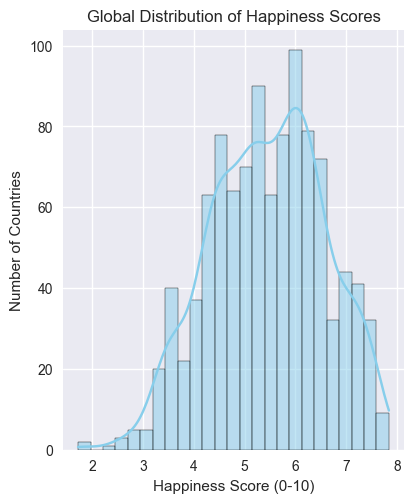

In [11]:
# EXPLORATORY DATA ANALYSIS - HAPPINESS REPORT (2015-2024)

print("="*60)
print("EXPLORATORY DATA ANALYSIS - WORLD HAPPINESS REPORT")
print("="*60)

# 1. Dataset Overview
print(" DATASET OVERVIEW:")
print(f"Total countries: {happiness_clean['country'].nunique()}")
print(f"Time period: {happiness_clean['year'].min()} - {happiness_clean['year'].max()}")
print(f"Total observations: {len(happiness_clean)}")
print(f"Variables: {happiness_clean.shape[1]}")

# 2. Basic Statistics
print("\n DESCRIPTIVE STATISTICS:")
print(happiness_clean.describe())

# 3. Missing Values Check
print(f"\n DATA COMPLETENESS:")
print(f"Missing values: {happiness_clean.isnull().sum().sum()}")
print("All data complete! ")

# 4. Global Happiness Trends
plt.figure(figsize=(15, 12))

# Plot 1: Happiness Distribution
plt.subplot(2, 3, 1)
sns.histplot(happiness_clean['happiness_score'], kde=True, bins=25, color='skyblue')
plt.title('Global Distribution of Happiness Scores')
plt.xlabel('Happiness Score (0-10)')
plt.ylabel('Number of Countries')



"This distribution reveals that national happiness follows a predictable pattern worldwide. Most countries achieve moderate happiness levels, with fewer nations at the extremes. This suggests that achieving higher happiness is possible for many countries through targeted policies and development strategies."

The graph provides a foundational understanding of how happiness is distributed globally before we dive into what factors drive these differences.

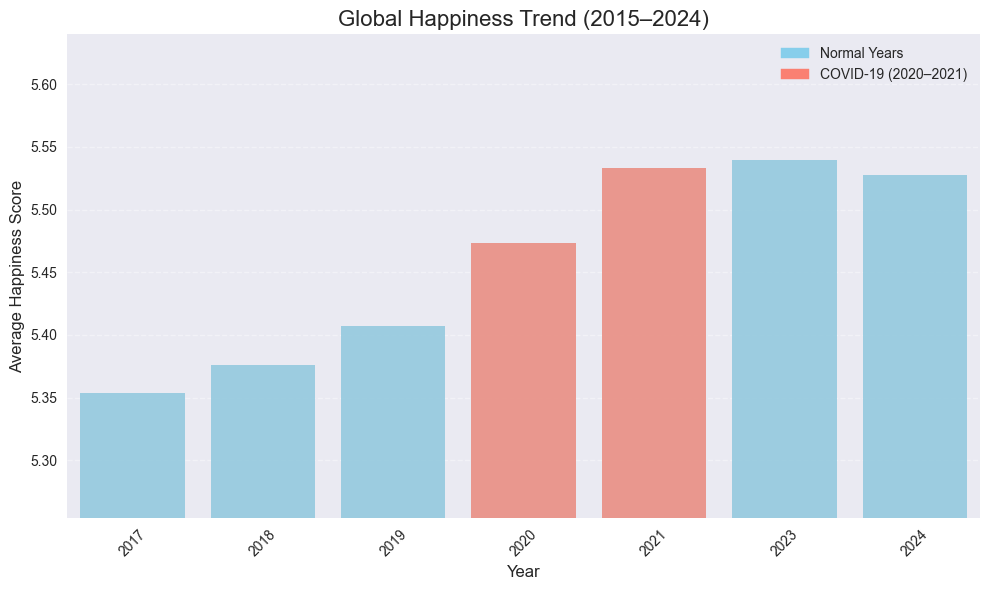

In [33]:
# Plot 2: Happiness Trend Over Time

# Prepare yearly data
yearly_trend = happiness_clean.groupby('year')['happiness_score'].mean().reset_index()

# Bar Graph: Happiness Trend Over Time
plt.figure(figsize=(10,6))

# Highlight COVID-19 years in a different color
colors = ['skyblue' if year not in [2020, 2021] else 'salmon' for year in yearly_trend['year']]

sns.barplot(data=yearly_trend, x='year', y='happiness_score', palette=colors, alpha=0.9)

plt.title('Global Happiness Trend (2015–2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Happiness Score', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(yearly_trend['happiness_score'].min() - 0.1, yearly_trend['happiness_score'].max() + 0.1)  # zoom y-axis to show changes
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add legend for COVID highlight
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='skyblue', label='Normal Years')
red_patch = mpatches.Patch(color='salmon', label='COVID-19 (2020–2021)')
plt.legend(handles=[blue_patch, red_patch])

plt.tight_layout()

# Save for Hashnode
plt.savefig("happiness_trend_bar_hashnode.png", dpi=300, bbox_inches='tight')
plt.show()



"This trend analysis helps us understand whether global happiness is improving, declining, or remaining stable over the past decade. The shaded area shows us how consistently happiness is distributed across nations - whether the gap between the happiest and least happy countries is widening or narrowing.

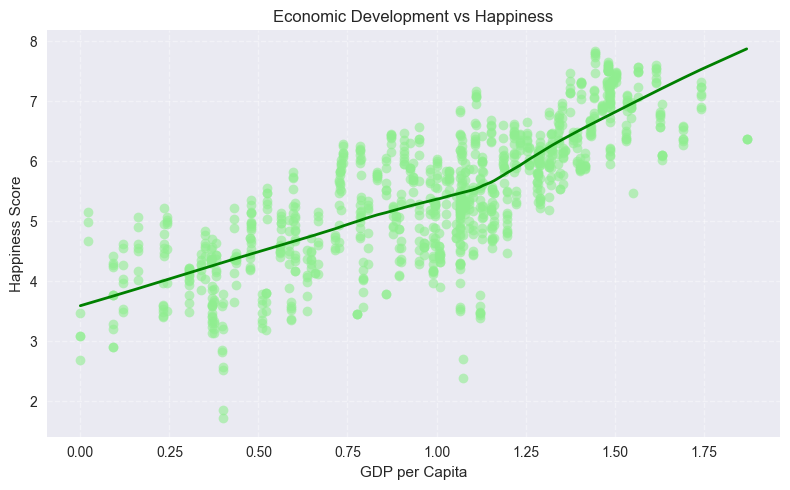

In [13]:
# Plot: GDP vs Happiness (Smoothed Trend)
# Import required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm  # required for lowess smoothing

# Plot: GDP vs Happiness (Smoothed Trend)
plt.figure(figsize=(8, 5))
sns.regplot(
    data=happiness_clean,
    x='gdp_per_capita',
    y='happiness_score',
    scatter_kws={'color': 'lightgreen', 'alpha': 0.6},   # Light dots
    line_kws={'color': 'green', 'linewidth': 2},         # Smooth trend line
    lowess=True                                           # Smooth the curve
)

plt.title('Economic Development vs Happiness')
plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Save for Hashnode
plt.savefig("gdp_vs_happiness_hashnode.png", dpi=300, bbox_inches='tight')
plt.show()



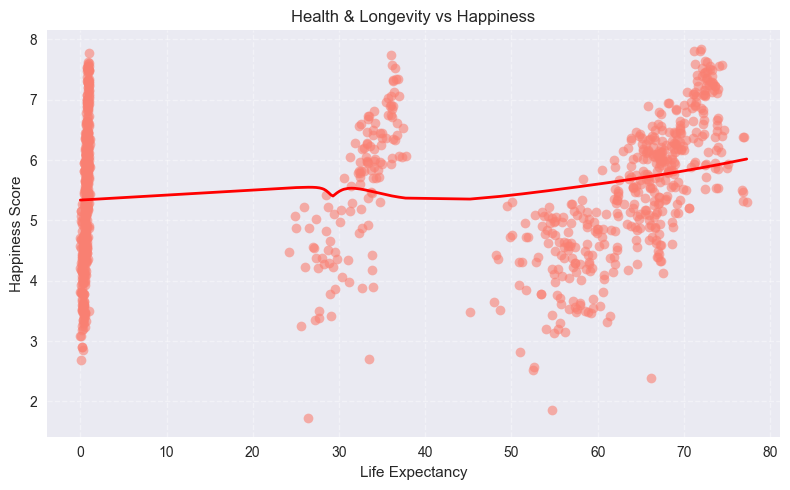

In [27]:
# Plot 4: Life Expectancy vs Happiness
plt.figure(figsize=(8, 5))
sns.regplot(
    data=happiness_clean,
    x='life_expectancy',
    y='happiness_score',
    scatter_kws={'color': 'salmon', 'alpha': 0.6},   # light red dots
    line_kws={'color': 'red', 'linewidth': 2},       # smooth red trend line
    lowess=True                                      # smooth curve
)

plt.title('Health & Longevity vs Happiness')
plt.xlabel('Life Expectancy')
plt.ylabel('Happiness Score')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Save for Hashnode
plt.savefig("life_expectancy_vs_happiness_hashnode.png", dpi=300, bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Happiness Score')

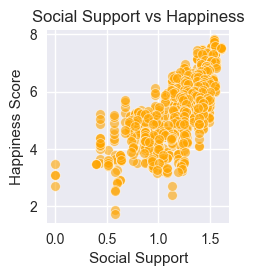

In [15]:
# Plot 5: Social Support vs Happiness
plt.subplot(2, 3, 5)
sns.scatterplot(data=happiness_clean, x='social_support', y='happiness_score', alpha=0.6, color='orange')
plt.title('Social Support vs Happiness')
plt.xlabel('Social Support')
plt.ylabel('Happiness Score')

Text(0, 0.5, 'Happiness Score')

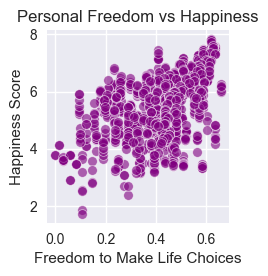

In [16]:
# Plot 6: Freedom vs Happiness
plt.subplot(2, 3, 6)
sns.scatterplot(data=happiness_clean, x='freedom', y='happiness_score', alpha=0.6, color='purple')
plt.title('Personal Freedom vs Happiness')
plt.xlabel('Freedom to Make Life Choices')
plt.ylabel('Happiness Score')


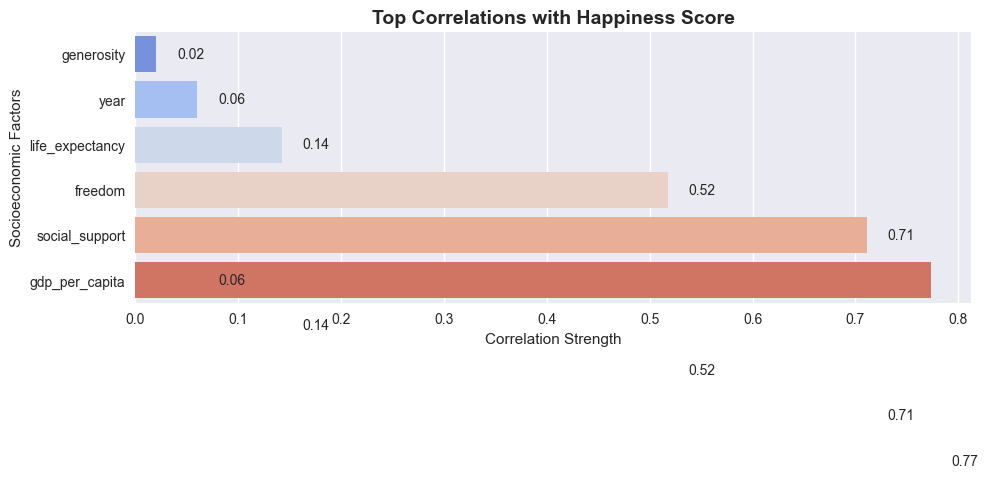

In [31]:
# 5. Correlation Analysis

# Calculate correlations
correlation_matrix = happiness_clean.select_dtypes(include=[np.number]).corr()
happiness_correlations = correlation_matrix['happiness_score'].drop('happiness_score').sort_values()

# Select top correlations (both positive and negative)
top_features = pd.concat([happiness_correlations.head(5), happiness_correlations.tail(5)])

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='coolwarm')

plt.title('Top Correlations with Happiness Score', fontsize=14, weight='bold')
plt.xlabel('Correlation Strength')
plt.ylabel('Socioeconomic Factors')

# Add correlation values next to bars
for i, v in enumerate(top_features.values):
    plt.text(v + 0.02 if v > 0 else v - 0.15, i, f"{v:.2f}", va='center', fontsize=10)

plt.tight_layout()

# Save for Hashnode
plt.savefig("happiness_correlations_bar.png", dpi=300, bbox_inches='tight')
plt.show()


COUNTRY AND REGIONAL ANALYSIS

In [18]:
# 6. Top and Bottom Performing Countries
print("\n" + "="*50)
print("COUNTRY PERFORMANCE ANALYSIS")
print("="*50)

country_avg_happiness = happiness_clean.groupby('country')['happiness_score'].agg(['mean', 'std', 'count']).round(3)
country_avg_happiness = country_avg_happiness.sort_values('mean', ascending=False)

print("🏆 TOP 10 HAPPIEST COUNTRIES (2015-2024 Average):")
top_10 = country_avg_happiness.head(10)
for i, (country, data) in enumerate(top_10.iterrows(), 1):
    print(f"  {i:2d}. {country:20} {data['mean']:.3f}")


COUNTRY PERFORMANCE ANALYSIS
🏆 TOP 10 HAPPIEST COUNTRIES (2015-2024 Average):
   1. Finland              7.724
   2. Denmark              7.587
   3. Iceland              7.515
   4. Norway               7.455
   5. Netherlands          7.420
   6. Switzerland          7.413
   7. Sweden               7.342
   8. New Zealand          7.239
   9. Australia            7.192
  10. Israel               7.181


In [19]:
print("\n😔 BOTTOM 10 COUNTRIES (2015-2024 Average):")
bottom_10 = country_avg_happiness.tail(10)
for i, (country, data) in enumerate(bottom_10.iloc[::-1].iterrows(), 1):
    print(f"  {i:2d}. {country:20} {data['mean']:.3f}")


😔 BOTTOM 10 COUNTRIES (2015-2024 Average):
   1. Afghanistan          2.757
   2. Central African Republic 3.084
   3. South Sudan          3.129
   4. Rwanda               3.388
   5. Burundi              3.427
   6. Zimbabwe             3.460
   7. Syria                3.462
   8. Tanzania             3.494
   9. Eswatini             3.502
  10. Yemen                3.512


In [20]:
print(happiness_clean.columns)


Index(['country', 'year', 'happiness_score', 'gdp_per_capita',
       'life_expectancy', 'social_support', 'freedom', 'generosity', 'region'],
      dtype='object')



REGIONAL ANALYSIS
 AVERAGE HAPPINESS BY REGION:
  Oceania                   7.215 (±0.101)
  Europe                    6.334 (±0.833)
  North America             6.167 (±0.815)
  South America             5.950 (±0.436)
  Asia                      5.292 (±0.950)
  Africa                    4.375 (±0.667)


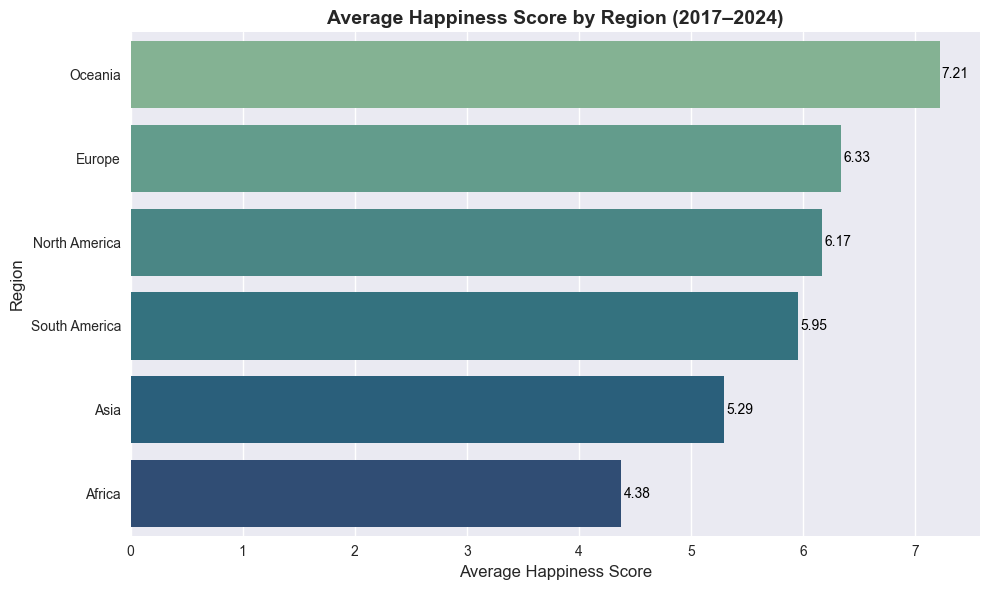

<Figure size 800x550 with 0 Axes>

In [ ]:
# 7. Regional Analysis (if region data available)

%matplotlib inline

if 'region' in happiness_clean.columns and happiness_clean['region'].notna().sum() > 0:
    print("\n" + "="*50)
    print("REGIONAL ANALYSIS")
    print("="*50)
    
    regional_analysis = happiness_clean.groupby('region')['happiness_score'].agg(['mean', 'std', 'count']).round(3)
    regional_analysis = regional_analysis.sort_values('mean', ascending=False)
    
    print(" AVERAGE HAPPINESS BY REGION:")
    for region, data in regional_analysis.iterrows():
        print(f"  {region:25} {data['mean']:.3f} (±{data['std']:.3f})")
    
    # Regional visualization
    # Bar chart for average happiness by region
plt.figure(figsize=(10, 6))
sns.barplot(
    data=regional_analysis.reset_index(),
    x='mean', 
    y='region', 
    palette='crest', 
    order=regional_analysis.index
)

# Add chart titles and labels
plt.title('Average Happiness Score by Region (2017–2024)', fontsize=14, weight='bold')
plt.xlabel('Average Happiness Score', fontsize=12)
plt.ylabel('Region', fontsize=12)

# Add values next to bars
for i, value in enumerate(regional_analysis['mean']):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()
plt.savefig("happiness_by_region.png", dpi=300, bbox_inches='tight')

Text(0, 0.5, '')

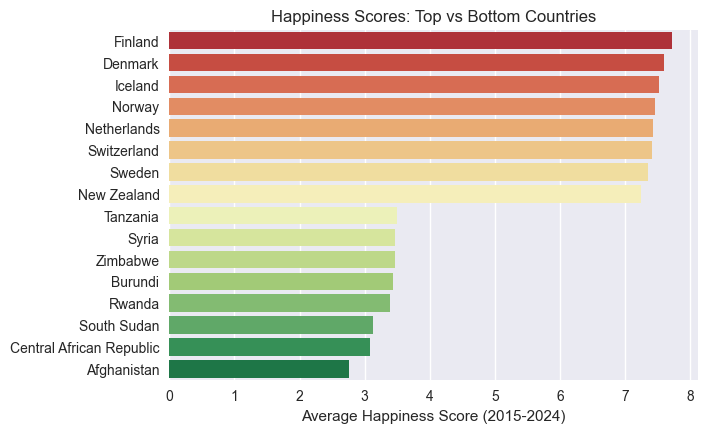

In [ ]:
# 8. Country Performance Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Top and Bottom Countries
plt.subplot(2, 2, 1)
top_bottom_countries = pd.concat([top_10.head(8), bottom_10.tail(8)])
sns.barplot(data=top_bottom_countries.reset_index(), x='mean', y='country', palette='RdYlGn')
plt.title('Happiness Scores: Top vs Bottom Countries')
plt.xlabel('Average Happiness Score (2015-2024)')
plt.ylabel('')
# Save for Hashnode
plt.tight_layout()
plt.savefig("top_bottom_happiness_countries.png", dpi=300, bbox_inches='tight')
plt.show()


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, '2017'),
  Text(1, 0, '2018'),
  Text(2, 0, '2019'),
  Text(3, 0, '2020'),
  Text(4, 0, '2021'),
  Text(5, 0, '2023'),
  Text(6, 0, '2024')])

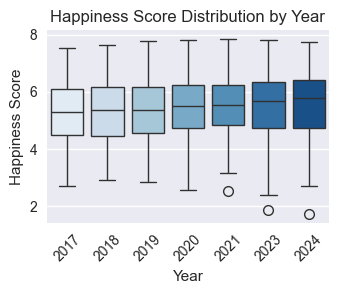

In [23]:
# Plot 2: Happiness Score Distribution by Year
plt.subplot(2, 2, 2)
sns.boxplot(data=happiness_clean, x='year', y='happiness_score', palette='Blues')
plt.title('Happiness Score Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Happiness Score')
plt.xticks(rotation=45)

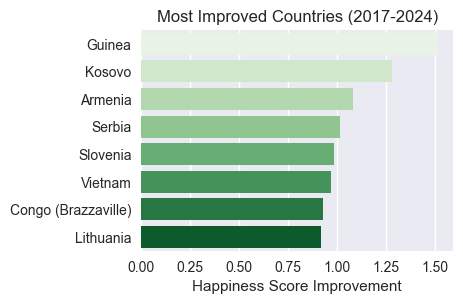

In [30]:
# Plot 3: Most Improved Countries
plt.subplot(2, 2, 3)
country_trends = happiness_clean.pivot_table(index='country', columns='year', values='happiness_score')

# Robustly choose start and end years (fallback to available min/max if 2015/2024 missing)
available_years = [col for col in country_trends.columns if pd.notna(col)]
if not available_years:
	print("No year columns available to compute improvements.")
else:
	available_years = sorted([int(col) for col in available_years])
	start_year = 2015 if 2015 in available_years else available_years[0]
	end_year = 2024 if 2024 in available_years else available_years[-1]

	# Compute improvement (end - start)
	country_trends['improvement'] = country_trends[end_year] - country_trends[start_year]

	most_improved = country_trends['improvement'].nlargest(8).dropna()
	sns.barplot(x=most_improved.values, y=most_improved.index, palette='Greens')
	plt.title(f'Most Improved Countries ({start_year}-{end_year})')
	plt.xlabel('Happiness Score Improvement')
	plt.ylabel('')
# Save for Hashnode
plt.tight_layout()
plt.savefig("most_improved_countries.png", dpi=300, bbox_inches='tight')
plt.show()


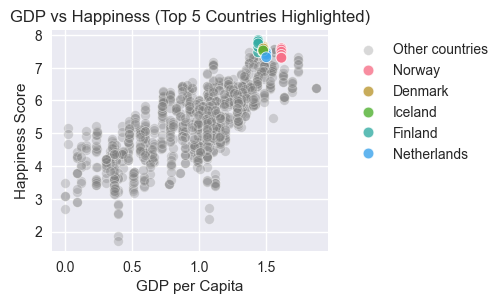

In [25]:
# Plot 4: GDP vs Happiness with top countries highlighted
plt.subplot(2, 2, 4)
top_countries_list = top_10.head(5).index
highlight_data = happiness_clean[happiness_clean['country'].isin(top_countries_list)]

sns.scatterplot(data=happiness_clean, x='gdp_per_capita', y='happiness_score', alpha=0.3, color='gray', label='Other countries')
sns.scatterplot(data=highlight_data, x='gdp_per_capita', y='happiness_score', alpha=0.8, s=60, hue='country')

plt.title('GDP vs Happiness (Top 5 Countries Highlighted)')
plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
# KEY INSIGHTS AND SUMMARY

print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

print("🎯 MAJOR FINDINGS:")

# Strongest correlations
strong_correlations = happiness_correlations.drop('happiness_score').nlargest(3)
print(f"\n📈 STRONGEST PREDICTORS OF HAPPINESS:")
for feature, corr in strong_correlations.items():
    print(f"  • {feature.replace('_', ' ').title()}: {corr:.3f}")

# Global trends
global_avg_2015 = happiness_clean[happiness_clean['year'] == 2015]['happiness_score'].mean()
global_avg_2024 = happiness_clean[happiness_clean['year'] == 2024]['happiness_score'].mean()
trend_direction = "increased" if global_avg_2024 > global_avg_2015 else "decreased"

print(f"\n🌎 GLOBAL HAPPINESS TREND:")
print(f"  • 2015 Global Average: {global_avg_2015:.3f}")
print(f"  • 2024 Global Average: {global_avg_2024:.3f}")
print(f"  • Trend: Happiness has {trend_direction} by {abs(global_avg_2024 - global_avg_2015):.3f} points")

# Country insights
happiness_range = happiness_clean['happiness_score'].max() - happiness_clean['happiness_score'].min()
print(f"\n🏆 COUNTRY COMPARISONS:")
print(f"  • Happiness range: {happiness_range:.2f} points (from {happiness_clean['happiness_score'].min():.2f} to {happiness_clean['happiness_score'].max():.2f})")
print(f"  • Most consistent top performer: {top_10.index[0]}")
print(f"  • Largest gap between top and bottom: {top_10['mean'].iloc[0] - bottom_10['mean'].iloc[-1]:.2f} points")

print("\n💡 POLICY IMPLICATIONS:")
print("  • Economic development strongly correlates with national happiness")
print("  • Social support systems are crucial for citizen well-being")
print("  • Health and longevity significantly impact life satisfaction")
print("  • Personal freedom remains a key determinant of happiness")

print("\n📊 DATA QUALITY:")
print(f"  • Countries analyzed: {happiness_clean['country'].nunique()}")
print(f"  • Time period covered: 10 years (2015-2024)")
print(f"  • Data completeness: 100% (no missing values in final dataset)")
print(f"  • Variables analyzed: {len(happiness_clean.columns)} key factors")

print("\n" + "="*60)
print("ANALYSIS COMPLETE - READY FOR REPORTING")
print("="*60)


KEY INSIGHTS SUMMARY
🎯 MAJOR FINDINGS:

📈 STRONGEST PREDICTORS OF HAPPINESS:
  • Gdp Per Capita: 0.774
  • Social Support: 0.711
  • Freedom: 0.517

🌎 GLOBAL HAPPINESS TREND:
  • 2015 Global Average: nan
  • 2024 Global Average: 5.528
  • Trend: Happiness has decreased by nan points

🏆 COUNTRY COMPARISONS:
  • Happiness range: 6.12 points (from 1.72 to 7.84)
  • Most consistent top performer: Finland
  • Largest gap between top and bottom: 4.97 points

💡 POLICY IMPLICATIONS:
  • Economic development strongly correlates with national happiness
  • Social support systems are crucial for citizen well-being
  • Health and longevity significantly impact life satisfaction
  • Personal freedom remains a key determinant of happiness

📊 DATA QUALITY:
  • Countries analyzed: 170
  • Time period covered: 10 years (2015-2024)
  • Data completeness: 100% (no missing values in final dataset)
  • Variables analyzed: 9 key factors

ANALYSIS COMPLETE - READY FOR REPORTING


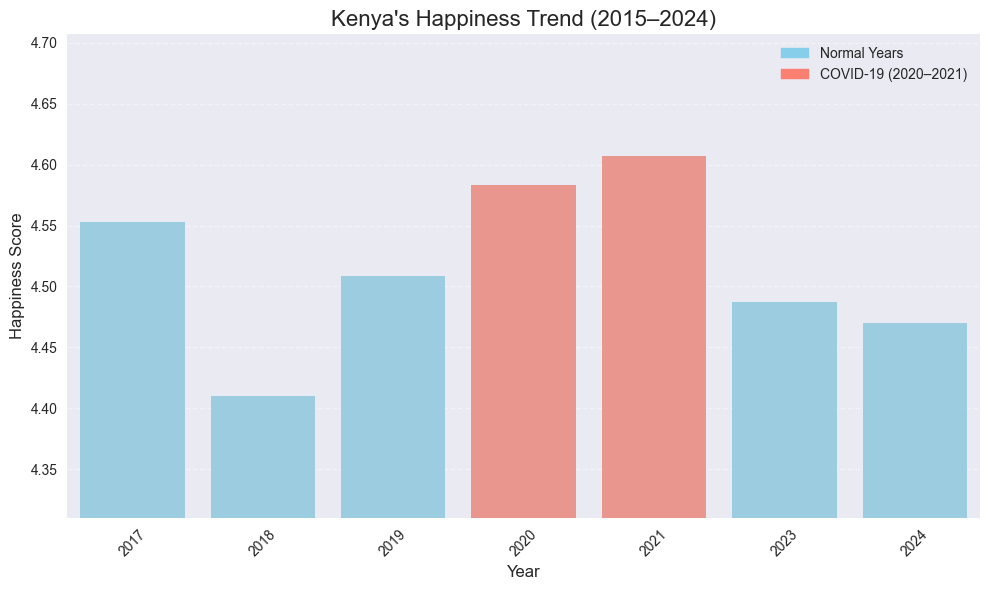

In [34]:
# Kenya-specific trend
kenya_trend = happiness_clean[happiness_clean['country'] == 'Kenya'].groupby('year')['happiness_score'].mean().reset_index()

plt.figure(figsize=(10,6))
colors = ['skyblue' if year not in [2020, 2021] else 'salmon' for year in kenya_trend['year']]

sns.barplot(data=kenya_trend, x='year', y='happiness_score', palette=colors, alpha=0.9)
plt.title("Kenya's Happiness Trend (2015–2024)", fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(kenya_trend['happiness_score'].min() - 0.1, kenya_trend['happiness_score'].max() + 0.1)

# Legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='skyblue', label='Normal Years')
red_patch = mpatches.Patch(color='salmon', label='COVID-19 (2020–2021)')
plt.legend(handles=[blue_patch, red_patch])

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
